데이터 로딩 중...
원본 데이터 형태: Features=(50910, 5, 62), Labels=(50910,)
전처리 후 데이터: (34350, 310)
클래스 분포: 부정(0)=16800, 긍정(1)=17550

[데이터 분할 완료]
타인 데이터(학습용): 32060개
나의 데이터(검증용): 2290개

1. 일반 모델 (타인 데이터로 학습 -> 내 감정 맞추기)
General Model 정확도: 0.5009 (50.09%)

상세 리포트:
              precision    recall  f1-score   support

    Negative       0.49      1.00      0.66      1120
    Positive       1.00      0.02      0.05      1170

    accuracy                           0.50      2290
   macro avg       0.75      0.51      0.35      2290
weighted avg       0.75      0.50      0.35      2290


2. 개인화 모델 (타인 + 내 데이터 일부 학습)
Personalized Model 정확도: 0.5420 (54.20%)


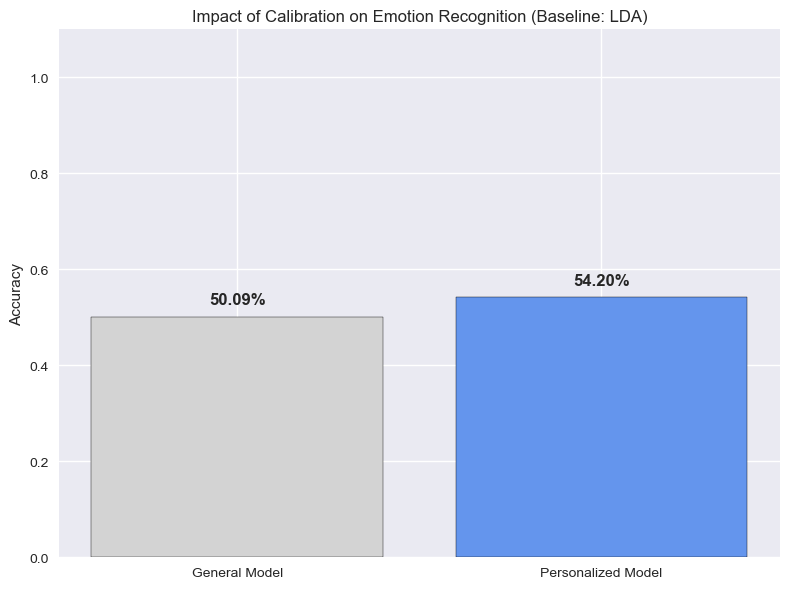

개인화(Calibration) 적용 시 정확도가 4.12%p 향상


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

plt.style.use('seaborn-v0_8')

# 1. 데이터 로드 및 전처리
def load_and_preprocess_data(dataset_path, labels_path, subjects_path):
    print("데이터 로딩 중...")
    
    features = np.load(dataset_path)['arr_0'] 
    labels = np.load(labels_path)['arr_0']     
    subjects = np.load(subjects_path)['arr_0']  
    
    print(f"원본 데이터 형태: Features={features.shape}, Labels={labels.shape}")
    
    # 1) 데이터 펼치기 (Flattening)
    # 머신러닝(LDA) 입력을 위해 (5개 대역 x 62채널)을 1차원(310개)으로 변환
    X = features.reshape(features.shape[0], -1) # (Samples, 310)
    
    # 2) 라벨 필터링 
    # 중립(1) 제거, 긍정(2) -> 1, 부정(0) -> 0
    
    # 중립(1)이 아닌 인덱스 찾기
    valid_idx = np.where(labels != 1)[0]
    
    X_filtered = X[valid_idx]
    y_filtered = labels[valid_idx]
    sub_filtered = subjects[valid_idx]
    
    # 긍정 라벨 변환 (2 -> 1)
    y_filtered = np.where(y_filtered == 2, 1, y_filtered)
    
    print(f"전처리 후 데이터: {X_filtered.shape}")
    print(f"클래스 분포: 부정(0)={np.sum(y_filtered==0)}, 긍정(1)={np.sum(y_filtered==1)}")
    
    return X_filtered, y_filtered, sub_filtered

# 2. 실행

dataset_file = '../assets/DatasetCaricatoNoImage.npz'
labels_file = '../assets/LabelsNoImage.npz'
subjects_file = '../assets/SubjectsNoImage.npz'

# 데이터 로드
X, y, subjects = load_and_preprocess_data(dataset_file, labels_file, subjects_file)

# 데이터 분할: 나(Subject 0) vs 타인(Subject 1~14)
target_subject_id = 0 # 0번 피험자

# 타인 데이터 (Source Domain)
source_idx = np.where(subjects != target_subject_id)[0]
X_source = X[source_idx]
y_source = y[source_idx]

# 나의 데이터 (Target Domain)
target_idx = np.where(subjects == target_subject_id)[0]
X_target = X[target_idx]
y_target = y[target_idx]

print(f"\n[데이터 분할 완료]")
print(f"타인 데이터(학습용): {len(X_source)}개")
print(f"나의 데이터(검증용): {len(X_target)}개")

# 정규화 (Standard Scaling)
scaler = StandardScaler()
X_source_scaled = scaler.fit_transform(X_source) # 타인 데이터로 기준점 잡기
X_target_scaled = scaler.transform(X_target)     

# 3. 실험 1: 일반 모델 (General Model)
print("\n1. 일반 모델 (타인 데이터로 학습 -> 내 감정 맞추기)")
model_general = LDA()
model_general.fit(X_source_scaled, y_source) # 타인 데이터로만 학습

y_pred_general = model_general.predict(X_target_scaled)
acc_general = accuracy_score(y_target, y_pred_general)

print(f"General Model 정확도: {acc_general:.4f} ({acc_general*100:.2f}%)")
print("\n상세 리포트:")
print(classification_report(y_target, y_pred_general, target_names=['Negative', 'Positive']))

# 4. 실험 2: 개인화 모델 (Personalized / Calibration)
print("\n2. 개인화 모델 (타인 + 내 데이터 일부 학습)")

# 내 데이터를 [Calibration용(20%)]과 [Test용(80%)]으로 분리
X_calib, X_test_personal, y_calib, y_test_personal = train_test_split(
    X_target_scaled, y_target, test_size=0.8, shuffle=False
)


# 학습 데이터 합치기 (타인 전체 + 내꺼 조금)
X_train_personal = np.vstack((X_source_scaled, X_calib))
y_train_personal = np.concatenate((y_source, y_calib))

# 모델 재학습
model_personal = LDA()
model_personal.fit(X_train_personal, y_train_personal)

# 평가
y_pred_personal = model_personal.predict(X_test_personal)
acc_personal = accuracy_score(y_test_personal, y_pred_personal)

print(f"Personalized Model 정확도: {acc_personal:.4f} ({acc_personal*100:.2f}%)")

# 5. 결과 시각화
plt.figure(figsize=(8, 6))
methods = ['General Model', 'Personalized Model']
scores = [acc_general, acc_personal]
colors = ['lightgray', 'cornflowerblue']

bars = plt.bar(methods, scores, color=colors, edgecolor='black')

plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.title('Impact of Calibration on Emotion Recognition (Baseline: LDA)')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02, f'{height*100:.2f}%', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"개인화(Calibration) 적용 시 정확도가 {acc_personal*100 - acc_general*100:.2f}%p 향상")

데이터 로딩 및 피험자별 정규화 진행 중...

[Deep Learning 모델 학습 시작...]

1. [Baseline] LDA Model Detailed Report
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.85      0.93      0.88      1120
    Positive       0.92      0.84      0.88      1170

    accuracy                           0.88      2290
   macro avg       0.88      0.88      0.88      2290
weighted avg       0.89      0.88      0.88      2290


2. [Improved] Deep MLP (DBN-style) Detailed Report
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.91      0.88      0.90      1120
    Positive       0.89      0.92      0.90      1170

    accuracy                           0.90      2290
   macro avg       0.90      0.90      0.90      2290
weighted avg       0.90      0.90      0.90      2290



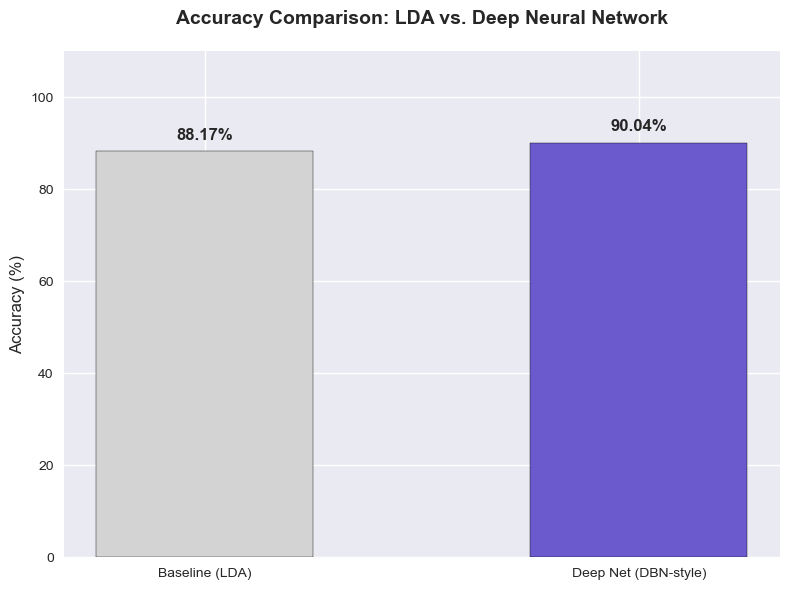

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# 1. 데이터 로드 및 피험자별 정규화 함수 (기존 로직 유지)
def load_and_preprocess_refined(dataset_path, labels_path, subjects_path):
    print("데이터 로딩 및 피험자별 정규화 진행 중...")
    features = np.load(dataset_path)['arr_0']
    labels = np.load(labels_path)['arr_0']
    subjects = np.load(subjects_path)['arr_0']
    
    X_scaled_list = []
    for sub_id in np.unique(subjects):
        mask = (subjects == sub_id)
        sub_data = features[mask].reshape(np.sum(mask), -1) # 310 차원
        scaler = StandardScaler()
        X_scaled_list.append(scaler.fit_transform(sub_data))
    
    X_final = np.vstack(X_scaled_list)
    valid_idx = np.where(labels != 1)[0]
    X_filt = X_final[valid_idx]
    y_filt = labels[valid_idx]
    sub_filt = subjects[valid_idx]
    y_filt = np.where(y_filt == 2, 1, y_filt)
    
    return X_filt, y_filt, sub_filt

# 2. DBN 스타일의 심층 신경망 정의
class EmotionDeepNet(nn.Module):
    def __init__(self, input_dim=310):
        super(EmotionDeepNet, self).__init__()
        # DBN의 계층적 구조를 반영한 Hidden Layers
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2) # 이진 분류 (Negative, Positive)
        )

    def forward(self, x):
        return self.network(x)

# 3. 데이터 준비
dataset_file = '../assets/DatasetCaricatoNoImage.npz'
labels_file = '../assets/LabelsNoImage.npz'
subjects_file = '../assets/SubjectsNoImage.npz'

X, y, subjects = load_and_preprocess_refined(dataset_file, labels_file, subjects_file)

# 실험 설정 (Subject 0을 테스트 대상으로 설정)
target_id = 0
X_train_raw = X[subjects != target_id]
y_train_raw = y[subjects != target_id]
X_test_raw = X[subjects == target_id]
y_test_raw = y[subjects == target_id]

# 4. 모델 1: LDA (Baseline)
model_lda = LDA()
model_lda.fit(X_train_raw, y_train_raw)
y_pred_lda = model_lda.predict(X_test_raw)
acc_lda = accuracy_score(y_test_raw, y_pred_lda)

# 5. 모델 2: DBN-inspired Deep MLP (PyTorch)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dnn = EmotionDeepNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dnn.parameters(), lr=0.001)

# PyTorch용 데이터셋 생성
train_ds = TensorDataset(torch.FloatTensor(X_train_raw), torch.LongTensor(y_train_raw))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

print("\n[Deep Learning 모델 학습 시작...]")
model_dnn.train()
for epoch in range(50): # 50 에포크 학습
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_dnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# 평가
model_dnn.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_raw).to(device)
    outputs = model_dnn(X_test_tensor)
    y_pred_dnn = torch.argmax(outputs, dim=1).cpu().numpy()
    acc_dnn = accuracy_score(y_test_raw, y_pred_dnn)

# 6. 상세 리포트 출력
print("\n" + "="*60)
print("1. [Baseline] LDA Model Detailed Report")
print("-" * 60)
print(classification_report(y_test_raw, y_pred_lda, target_names=['Negative', 'Positive']))

print("\n" + "="*60)
print("2. [Improved] Deep MLP (DBN-style) Detailed Report")
print("-" * 60)
print(classification_report(y_test_raw, y_pred_dnn, target_names=['Negative', 'Positive']))
print("="*60)

# 7. 시각화
plt.figure(figsize=(8, 6))
labels_plot = ['Baseline (LDA)', 'Deep Net (DBN-style)']
scores = [acc_lda * 100, acc_dnn * 100]
colors = ['#d3d3d3', '#6a5acd'] # 회색, 슬레이트 블루

bars = plt.bar(labels_plot, scores, color=colors, edgecolor='black', width=0.5)
plt.ylim(0, 110)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy Comparison: LDA vs. Deep Neural Network', fontsize=14, fontweight='bold', pad=20)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 2, f'{height:.2f}%', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Improved LDA Pure LOSO 검증 시작...
--------------------------------------------------
Subject 00 Accuracy: 93.54%
Subject 01 Accuracy: 72.10%
Subject 02 Accuracy: 72.18%
Subject 03 Accuracy: 91.14%
Subject 04 Accuracy: 75.55%
Subject 05 Accuracy: 82.40%
Subject 06 Accuracy: 45.94%
Subject 07 Accuracy: 87.86%
Subject 08 Accuracy: 88.52%
Subject 09 Accuracy: 81.79%
Subject 10 Accuracy: 82.31%
Subject 11 Accuracy: 60.52%
Subject 12 Accuracy: 77.99%
Subject 13 Accuracy: 88.95%
Subject 14 Accuracy: 99.39%


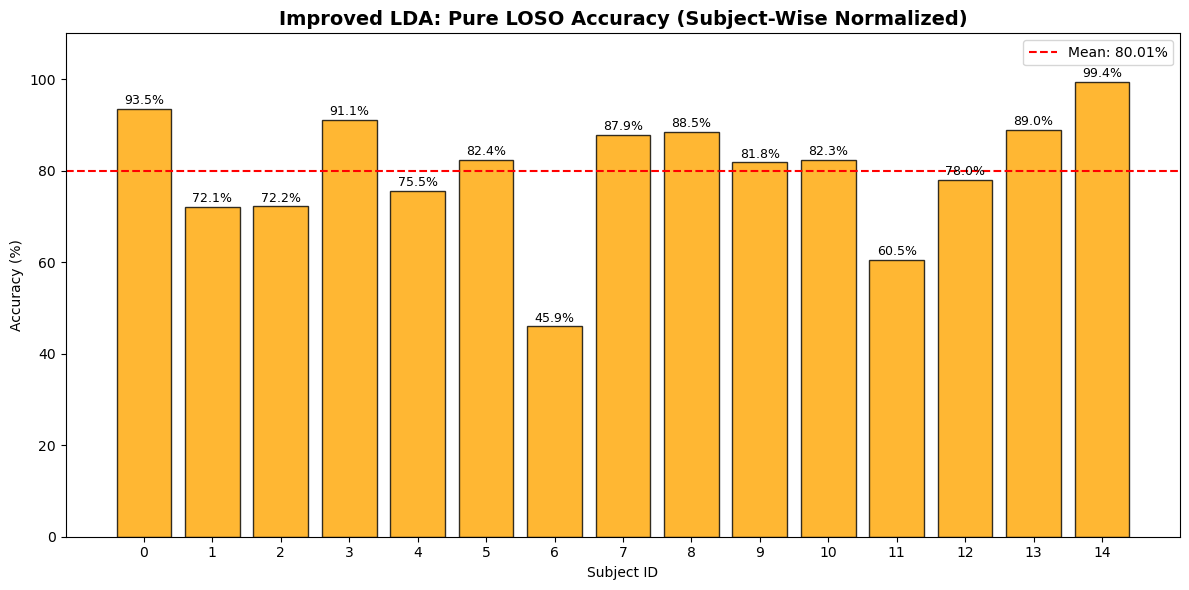


최종 평균 정확도 (LDA Mean): 80.01%
표준 편차 (Std Dev): 13.16%


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# 1. 데이터 로드 및 [개선] 피험자별 정규화 함수
def load_and_preprocess_loso(feat_p, lab_p, sub_p):
    X_raw = np.load(feat_p)['arr_0']
    y_raw = np.load(lab_p)['arr_0']
    s_raw = np.load(sub_p)['arr_0']
    
    # 중립(1) 제거 및 라벨 변환
    mask = (y_raw != 1)
    X = X_raw[mask].reshape(np.sum(mask), -1)
    y = np.where(y_raw[mask] == 2, 1, 0)
    subjects = s_raw[mask]
    
    # [핵심 개선] 피험자별 독립적 정규화 수행
    # 각 피험자의 데이터만 따로 떼어 스케일링하여 개인차 노이즈 제거
    X_scaled = np.zeros_like(X)
    unique_subs = np.unique(subjects)
    
    for sub_id in unique_subs:
        sub_mask = (subjects == sub_id)
        scaler = StandardScaler()
        X_scaled[sub_mask] = scaler.fit_transform(X[sub_mask])
        
    return X_scaled, y, subjects

# 2. LDA Pure LOSO 실행 엔진
def run_improved_lda_loso(X, y, subjects):
    unique_subs = np.unique(subjects)
    loso_results = []

    print("Improved LDA Pure LOSO 검증 시작...")
    print("-" * 50)

    for test_id in unique_subs:
        # 데이터 분할 (Pure LOSO: 테스트 피험자는 학습에 전혀 관여 안함)
        X_train = X[subjects != test_id]
        y_train = y[subjects != test_id]
        X_test = X[subjects == test_id]
        y_test = y[subjects == test_id]

        # 모델 학습 (LDA)
        model = LDA()
        model.fit(X_train, y_train)

        # 평가
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        loso_results.append(acc)
        
        print(f"Subject {test_id:02d} Accuracy: {acc*100:.2f}%")

    return unique_subs, np.array(loso_results)

# --- 메인 실행부 ---
feat_path = '../assets/DatasetCaricatoNoImage.npz'
lab_path = '../assets/LabelsNoImage.npz'
sub_path = '../assets/SubjectsNoImage.npz'

# 데이터 전처리 및 피험자별 스케일링 적용
X_proc, y_proc, s_proc = load_and_preprocess_loso(feat_path, lab_path, sub_path)

# LOSO 수행
subs, acc_list = run_improved_lda_loso(X_proc, y_proc, s_proc)

# 3. 결과 시각화
mean_lda = np.mean(acc_list) * 100
std_lda = np.std(acc_list) * 100

plt.figure(figsize=(12, 6))
bars = plt.bar(subs, acc_list * 100, color='orange', edgecolor='black', alpha=0.8)
plt.axhline(mean_lda, color='red', linestyle='--', label=f'Mean: {mean_lda:.2f}%')

plt.title('Improved LDA: Pure LOSO Accuracy (Subject-Wise Normalized)', fontsize=14, fontweight='bold')
plt.xlabel('Subject ID')
plt.ylabel('Accuracy (%)')
plt.xticks(subs)
plt.ylim(0, 110)
plt.legend()

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, h + 1, f'{h:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print(f"최종 평균 정확도 (LDA Mean): {mean_lda:.2f}%")
print(f"표준 편차 (Std Dev): {std_lda:.2f}%")
print("="*50)

Deep MLP 기반 Calibrated LOSO 시작 (Device: cpu)
Subject 00 Accuracy: 92.69%
Subject 01 Accuracy: 72.82%
Subject 02 Accuracy: 86.63%
Subject 03 Accuracy: 92.25%
Subject 04 Accuracy: 96.78%
Subject 05 Accuracy: 70.69%
Subject 06 Accuracy: 95.96%
Subject 07 Accuracy: 81.00%
Subject 08 Accuracy: 94.92%
Subject 09 Accuracy: 89.25%
Subject 10 Accuracy: 94.76%
Subject 11 Accuracy: 84.61%
Subject 12 Accuracy: 90.99%
Subject 13 Accuracy: 89.79%
Subject 14 Accuracy: 93.07%


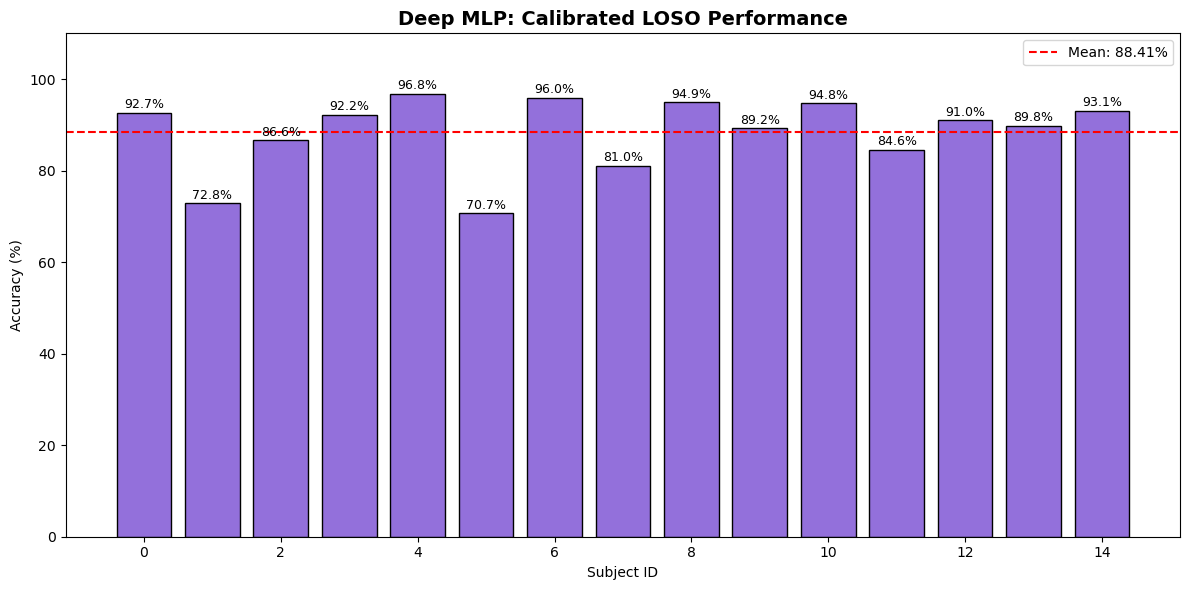


[최종 결과] 평균 정확도: 88.41%


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# 1. 모델 정의 (DBN의 다층 구조 반영)
class EmotionDeepNet(nn.Module):
    def __init__(self, input_dim=310):
        super(EmotionDeepNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2) # 긍정/부정 분류
        )

    def forward(self, x):
        return self.layers(x)

# 2. 데이터 로드 및 전처리
def load_and_filter_data(feat_path, lab_path, sub_path):
    X_raw = np.load(feat_path)['arr_0']
    y_raw = np.load(lab_path)['arr_0']
    s_raw = np.load(sub_path)['arr_0']
    
    # 중립(1) 제거 및 라벨 변환 (2 -> 1)
    mask = (y_raw != 1)
    X = X_raw[mask].reshape(np.sum(mask), -1)
    y = np.where(y_raw[mask] == 2, 1, 0)
    sub = s_raw[mask]
    return X, y, sub

# 3. 학습 함수
def train_step(model, loader, optimizer, criterion, device):
    model.train()
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# --- 메인 루프 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feat_p = '../assets/DatasetCaricatoNoImage.npz'
lab_p = '../assets/LabelsNoImage.npz'
sub_p = '../assets/SubjectsNoImage.npz'

X, y, subjects = load_and_filter_data(feat_p, lab_p, sub_p)
unique_subs = np.unique(subjects)
loso_accuracies = []

print(f"Deep MLP 기반 Calibrated LOSO 시작 (Device: {device})")

for test_id in unique_subs:
    # 데이터 분할
    X_src = X[subjects != test_id]
    y_src = y[subjects != test_id]
    X_tgt_all = X[subjects == test_id]
    y_tgt_all = y[subjects == test_id]
    
    # 캘리브레이션 분할 (20%)
    split = int(len(X_tgt_all) * 0.2)
    X_cal, y_cal = X_tgt_all[:split], y_tgt_all[:split]
    X_test, y_test = X_tgt_all[split:], y_tgt_all[split:]
    
    # 정규화
    sc = StandardScaler()
    X_train = np.vstack((X_src, X_cal))
    y_train = np.concatenate((y_src, y_cal))
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)
    
    # 텐서 변환
    train_ds = TensorDataset(torch.FloatTensor(X_train_sc), torch.LongTensor(y_train))
    train_ld = DataLoader(train_ds, batch_size=64, shuffle=True)
    X_test_t = torch.FloatTensor(X_test_sc).to(device)
    
    # 모델 초기화 및 학습
    model = EmotionDeepNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # 학습 (빠른 확인을 위해 20 에포크 설정)
    for epoch in range(20):
        train_step(model, train_ld, optimizer, criterion, device)
        
    # 평가
    model.eval()
    with torch.no_grad():
        preds = torch.argmax(model(X_test_t), dim=1).cpu().numpy()
        acc = accuracy_score(y_test, preds)
        loso_accuracies.append(acc)
    
    print(f"Subject {test_id:02d} Accuracy: {acc*100:.2f}%")

# 4. 시각화
mean_acc = np.mean(loso_accuracies) * 100
plt.figure(figsize=(12, 6))
bars = plt.bar(unique_subs, np.array(loso_accuracies) * 100, color='mediumpurple', edgecolor='black')
plt.axhline(mean_acc, color='red', linestyle='--', label=f'Mean: {mean_acc:.2f}%')
plt.title('Deep MLP: Calibrated LOSO Performance', fontsize=14, fontweight='bold')
plt.xlabel('Subject ID')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 110)
plt.legend()

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, h + 1, f'{h:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n[최종 결과] 평균 정확도: {mean_acc:.2f}%")